In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
from datetime import datetime
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
conn = engine.connect()

In [5]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [10]:
columns = inspector.get_columns('measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [11]:
# Find the most recent date in the data set.
#default of order_by is ascending
recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first().date
recent_date

'2017-08-23'

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.

# Perform a query to retrieve the date and precipitation scores
#Using this date (2017-08-23), retrieve the previous 12 months of precipitation data by querying the 12 previous months of data. 
#Note: Do not pass in the date as a variable to your query.

query_date = dt.date(2017, 8, 23) - dt.timedelta(days=365)
last_year_data = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= query_date).order_by(Measurement.date)

# no longer need below:
# for date in last_year_data:
#     print(f"{date.date}, {date.prcp}")
#don't need for loop below after fixing query above and including Measurement.date, Measurement.prcp
#measurements_results = [{"Date": result.date, "PRCP": result.prcp} for result in last_year_data]
#measurements_results

In [13]:
# checking that correct number of rows are pulled
last_year_data_count = session.query(Measurement).filter(Measurement.date >= '2016-08-23').count()
print(last_year_data_count)

2230


In [14]:
# Save the query results as a Pandas DataFrame and set the index to the date column

#precip_df = pd.read_sql("SELECT Measurement.date, Measurement.prcp FROM Measurement WHERE Measurement.date >= '2016-08-23'", conn)
#precip_df = pd.DataFrame(measurements_results).set_index("Date")

precip_df = pd.DataFrame(last_year_data, columns=["date", "precipitation"]).set_index("date")
precip_df

,precipitation
date,
2016-08-23,0.00
2016-08-23,0.15
2016-08-23,0.05
2016-08-23,NaN
2016-08-23,0.02
...,...
2017-08-22,0.50
2017-08-23,0.00
2017-08-23,0.00


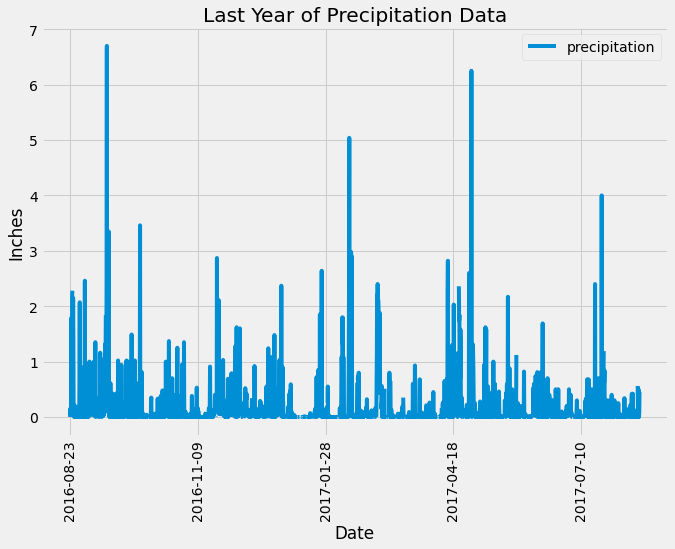

In [15]:
# Use Pandas Plotting with Matplotlib to plot the data
#precip_df.plot(xlabel='Date', ylabel='Inches', rot=90)
precip_df.plot(xlabel='Date', ylabel='Inches', rot=90, use_index=True, title="Last Year of Precipitation Data", figsize=(10,7)).legend(loc='upper right')

#worked with a Learning Assistant to try using xticks=df.index.tolist() but there were too many values - we couldn't figure out how to get the x axis to match the supplied image of the solution exactly

#precip_df.plot(x="Date", y="PRCP", xlabel='Date', ylabel='Inches', rot=90, figsize=(10,7))
#plt.legend(loc='upper right')
#plt.tight_layout()
#plt.show()

In [16]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precip_df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [17]:
# Design a query to calculate the total number stations in the dataset
session.query(Station).count()

9

In [18]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
session.query(Station.station, func.count(Measurement.station)).filter(Station.station == Measurement.station).group_by(Station.station).order_by(func.count(Measurement.station).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [19]:
# USC00519281 has the highest number of observations

In [20]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.

# lowest = session.query(Measurement.tobs).filter(Measurement.station == "USC00519281").order_by(Measurement.tobs).first()
# highest = session.query(Measurement.tobs).filter(Measurement.station == "USC00519281").order_by(Measurement.tobs.desc()).first()
# avg = session.query(func.avg(Measurement.tobs)).filter(Measurement.station == "USC00519281").first()

lowest = session.query(func.min(Measurement.tobs)).filter(Measurement.station == "USC00519281").scalar()
highest = session.query(func.max(Measurement.tobs)).filter(Measurement.station == "USC00519281").scalar()
avg = session.query(func.avg(Measurement.tobs)).filter(Measurement.station == "USC00519281").scalar()

print(f"The lowest temperature is: {lowest}")
print(f"The highest temperature is: {highest}")
print(f"The average temperature is: {avg}")

The lowest temperature is: 54.0
The highest temperature is: 85.0
The average temperature is: 71.66378066378067


In [21]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
station_recentdate = session.query(Measurement.date).filter(Measurement.station == "USC00519281").order_by(Measurement.date.desc()).first().date
station_recentdate

'2017-08-18'

In [22]:
# calculating time delta using most recent date of 2017-08-18
new_query_date = dt.date(2017, 8, 18) - dt.timedelta(days=365)

#querying with filter for station name and dates past the date calculated above
station_year_data = session.query(Measurement.date, Measurement.tobs).filter(Measurement.station == "USC00519281").filter(Measurement.date >= new_query_date).order_by(Measurement.date).all()

# no longer need below:
#station_year_data = session.query(Measurement).filter(Measurement.station == "USC00519281").filter(Measurement.date >= new_query_date).order_by(Measurement.date)
#temperature_results = [{"Date": result.date, "Temperature": result.tobs} for result in station_year_data]
#temperature_results
#print(station_year_data)

In [23]:
station_df = pd.DataFrame(station_year_data, columns=["date", "tobs"]).set_index("date")
station_df

,tobs
date,
2016-08-18,80.0
2016-08-19,79.0
2016-08-20,81.0
2016-08-21,79.0
2016-08-22,78.0
...,...
2017-08-14,77.0
2017-08-15,77.0
2017-08-16,76.0


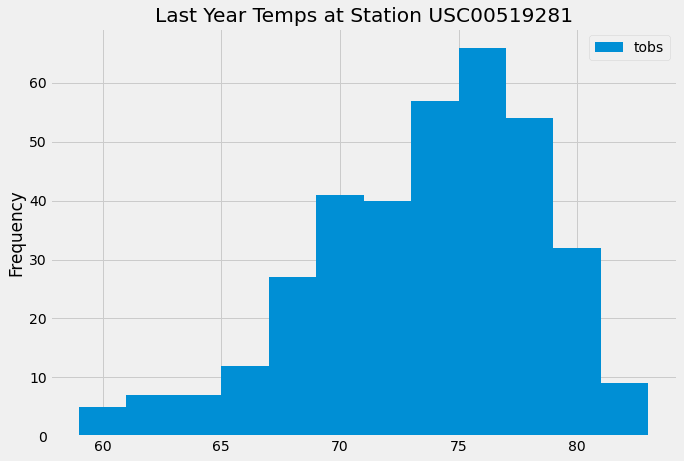

In [24]:
station_df.plot.hist(title="Last Year Temps at Station USC00519281", bins=12, figsize=(10,7)).legend(loc="upper right")
#NEED TO FIX - x label cut off

# Close session

In [25]:
# Close Session
session.close()